In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
display(device)

device(type='cuda')

In [3]:
np.random.seed(45)
num_samples = 40
    
# Generate data
x1 = np.random.uniform(-1, 1, num_samples)
f_x = 3*x1 + 4
eps = np.random.randn(num_samples)
y = f_x + eps

In [4]:
theta = torch.tensor([1., 1.], requires_grad=True, dtype=torch.float64)

In [5]:
x_tensor = torch.tensor(x1, dtype=torch.float64).reshape(-1, 1)
X = torch.cat((torch.ones(x_tensor.shape), x_tensor), 1)
y = torch.tensor(y, dtype=torch.float64).reshape(-1, 1)

def true_gradient():
    y_pred = (X @ theta).reshape(-1, 1)
    loss = torch.mean((y_pred - y) ** 2, dtype=torch.float64)
    loss.backward()
    true_grad = theta.grad.clone()
    true_loss = loss.data.clone()
    return true_grad, true_loss

true_grad, true_loss = true_gradient()
display(true_grad, true_loss, theta)

tensor([-5.6164, -0.5630], dtype=torch.float64)

tensor(9.3556, dtype=torch.float64)

tensor([1., 1.], dtype=torch.float64, requires_grad=True)

In [6]:
def compute_loss_analytical():
    x_tensor = X.clone().detach()
    y_tensor = y.clone().detach()
    theta_opt = torch.inverse(x_tensor.T @ x_tensor) @ x_tensor.T @ y_tensor
    y_pred_tensor = (x_tensor @ theta_opt).reshape(-1, 1)
    loss_opt = torch.mean((y_pred_tensor - y_tensor) ** 2, dtype=torch.float64)
    return loss_opt.item()

loss_opt = compute_loss_analytical()
display(loss_opt)

0.5957541565733318

In [7]:
def compute_sgd(x_i, y_i):
    theta.grad.zero_()
    y_pred_i = x_i @ theta
    loss_i = torch.mean((y_pred_i - y_i) ** 2, dtype=torch.float64)
    loss_i.backward()
    
    return theta.grad.clone()

stochastic_grads = []

for i in range(y.shape[0]):
    x_i = X[i].clone().detach()
    y_i = y[i].clone().detach()
    stochastic_grads.append(compute_sgd(x_i, y_i))

mean_stochastic_grad = torch.mean(torch.stack(stochastic_grads), dim=0)

display(mean_stochastic_grad)

tensor([-5.6164, -0.5630], dtype=torch.float64)

In [8]:
residual_tensor = true_grad - mean_stochastic_grad
display(residual_tensor)

tensor([-8.8818e-16, -1.1102e-16], dtype=torch.float64)

As we can observe from the above cell, the values in the residual tensor are all of the order $10^{-7}$, which indicates that the error is minimal. We can conclude that the stochastic gradient is a good estimate of the true gradient.

In [9]:
pretty_print = {'bgd': 'Batch Gradient Descent', 'mbgd': 'Mini-Batch Gradient Descent', 'sgd': 'Stochastic Gradient Descent'}

def gradient_descent(grad_type: str='bgd', epochs=50000, eps=1e-3, alpha=1e-1, minibatch_size=4, momentum=None):
    loss_vals = []
    theta_vals = []
    theta_copy = torch.randn(theta.shape, requires_grad=True, dtype=torch.float64)
    theta_copy.requires_grad = True
    epoch = 1
    latest_loss = 0
    change = torch.zeros(theta_copy.shape)
    iterations = 0
    while epoch <= epochs:
        if grad_type == 'bgd':
            y_pred = (X @ theta_copy).reshape(-1, 1)
            loss = torch.mean((y_pred - y) ** 2, dtype=torch.float64)
            loss.backward()
            # latest_loss = loss.item()

            with torch.no_grad():
                if momentum is not None:
                    new_change = alpha * theta_copy.grad + momentum * change
                    theta_copy -= new_change
                else:
                    theta_copy -= alpha * theta_copy.grad

            theta_copy.grad.zero_()

            y_pred_all = (X @ theta_copy).reshape(-1, 1)
            latest_loss = torch.mean((y_pred_all - y) ** 2).item()
            iterations += num_samples
        
        elif grad_type == 'mbgd':
            random_permutation = torch.randperm(num_samples)
            X_shuffled = X[random_permutation].clone().detach()
            y_shuffled = y[random_permutation].clone().detach()

            for i in range(0, num_samples, minibatch_size):
                X_batch = X_shuffled[i:i + minibatch_size].clone().detach()
                y_batch = y_shuffled[i:i + minibatch_size].clone().detach()
                y_pred = (X_batch @ theta_copy).reshape(-1, 1)
                
                loss = torch.mean((y_pred - y_batch) ** 2, dtype=torch.float64)
                loss.backward()
                # latest_loss = loss.item()

                with torch.no_grad():
                    if momentum is not None:
                        new_change = alpha * theta_copy.grad + momentum * change
                        theta_copy -= new_change
                    else:
                        theta_copy -= alpha * theta_copy.grad

                theta_copy.grad.zero_()
                iterations += minibatch_size

            y_pred_all = (X @ theta_copy).reshape(-1, 1)
            latest_loss = torch.mean((y_pred_all - y) ** 2).item()

        else:
            random_permutation = torch.randperm(num_samples)
            X_shuffled = X[random_permutation].clone().detach()
            y_shuffled = y[random_permutation].clone().detach()
            for i in range(num_samples):
                X_i = X_shuffled[i].clone().detach()
                y_i = y_shuffled[i].clone().detach()
                y_pred = (X_i @ theta_copy)

                loss = torch.mean((y_pred - y_i) ** 2, dtype=torch.float64)
                loss.backward()
                latest_loss = loss.item()

                with torch.no_grad():
                    if momentum is not None:
                        new_change = alpha * theta_copy.grad + momentum * change
                        theta_copy -= new_change
                    else:
                        theta_copy -= alpha * theta_copy.grad

                theta_copy.grad.zero_()

            y_pred_all = (X @ theta_copy).reshape(-1, 1)
            latest_loss = torch.mean((y_pred_all - y) ** 2).item()
            iterations += num_samples

        loss_vals.append(latest_loss)
        theta_vals.append(theta_copy.clone())

        if abs(loss_vals[-1] - loss_opt) <= eps:
            print(f'{pretty_print[grad_type]} converged in {epoch} epochs')
            return loss_vals, theta_vals, iterations

        epoch += 1
    return loss_vals, theta_vals, iterations
    

In [10]:
def plot_loss_vs_epochs(momentum=None):
    iters_per_class = {}
    for grad_type in ['bgd', 'mbgd', 'sgd']:
        losses, thetas, iters = gradient_descent(grad_type=grad_type, momentum = None)
        iters_per_class[pretty_print[grad_type]] = iters
        epochs = np.arange(1, len(losses) + 1, dtype=np.int32)
        display(pretty_print[grad_type], np.min(losses))
        plt.plot(epochs, losses, marker='.')
        plt.grid(visible=True)
        plt.title(f'Loss vs. Epochs for {pretty_print[grad_type]}')
        plt.xlim(left=1)
        plt.hlines(loss_opt, 0, len(epochs), linestyles='--', colors='red')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()
    plt.bar(['Batch', 'Mini-Batch', 'Stochastic'], iters_per_class.values())
    plt.title(f'(Yet to be) Average Iterations Per Method {"With" if momentum else "Without"} Momentum')
    plt.xlabel('Method of Gradient Descent')
    plt.ylabel('Number of Iterations')
    plt.show()

Batch Gradient Descent converged in 67 epochs


'Batch Gradient Descent'

0.5967263391644755

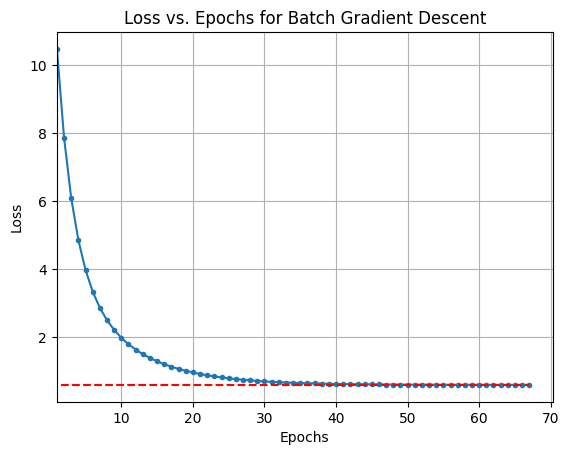

Mini-Batch Gradient Descent converged in 7 epochs


'Mini-Batch Gradient Descent'

0.5965197890100412

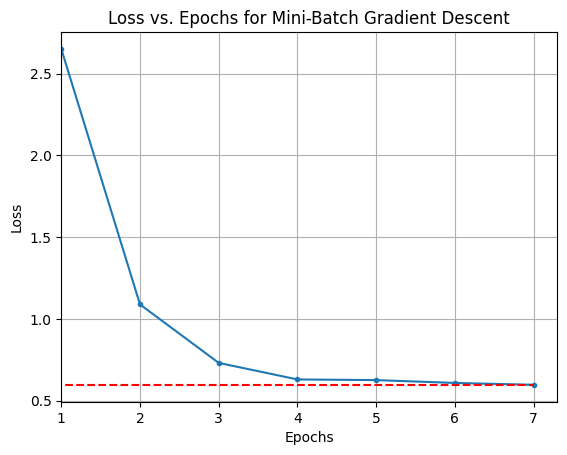

Stochastic Gradient Descent converged in 171 epochs


'Stochastic Gradient Descent'

0.5964982557579032

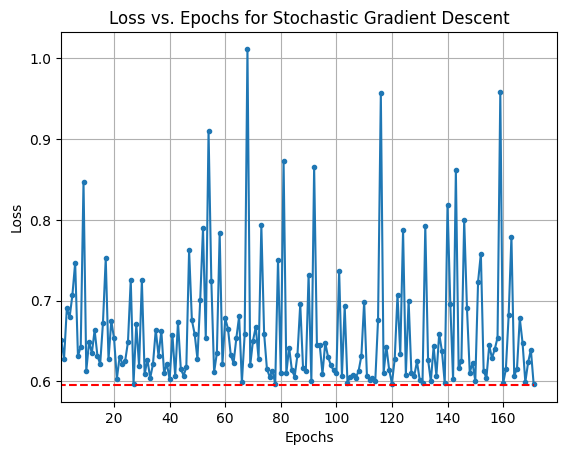

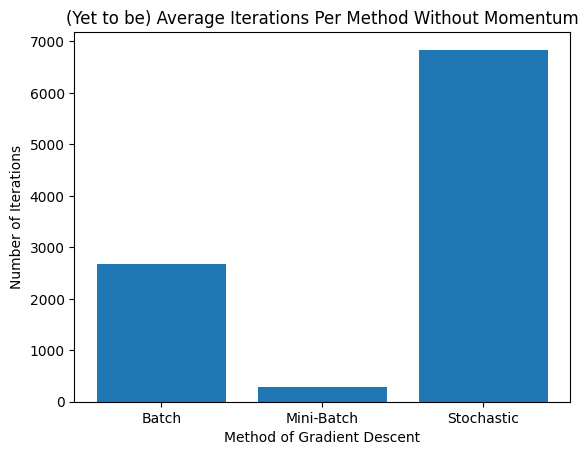

In [11]:
plot_loss_vs_epochs(momentum=None)

Batch Gradient Descent converged in 61 epochs


'Batch Gradient Descent'

0.5966879491440127

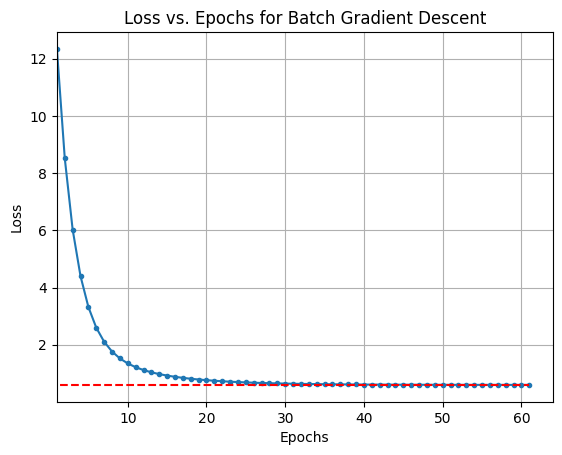

Mini-Batch Gradient Descent converged in 6 epochs


'Mini-Batch Gradient Descent'

0.5958414802012196

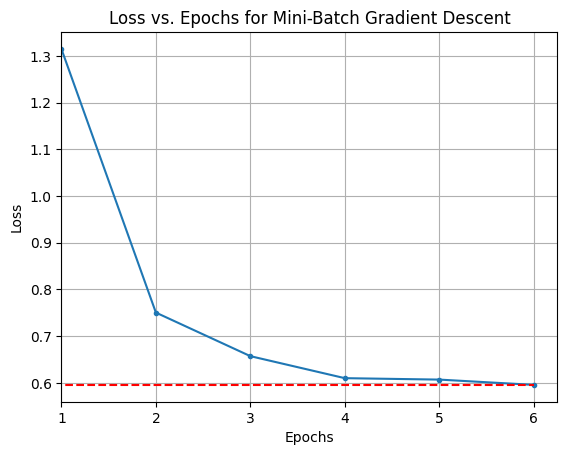

Stochastic Gradient Descent converged in 141 epochs


'Stochastic Gradient Descent'

0.5958370591526985

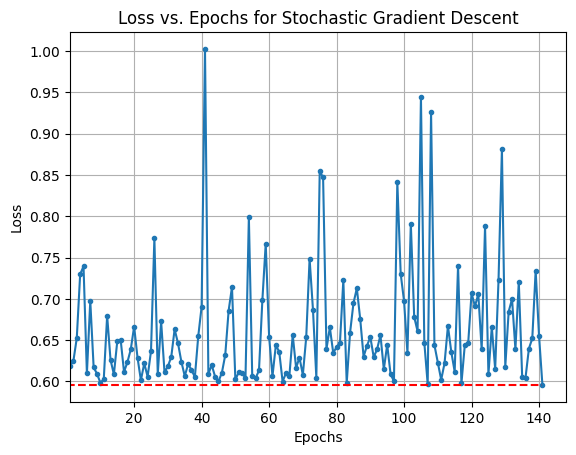

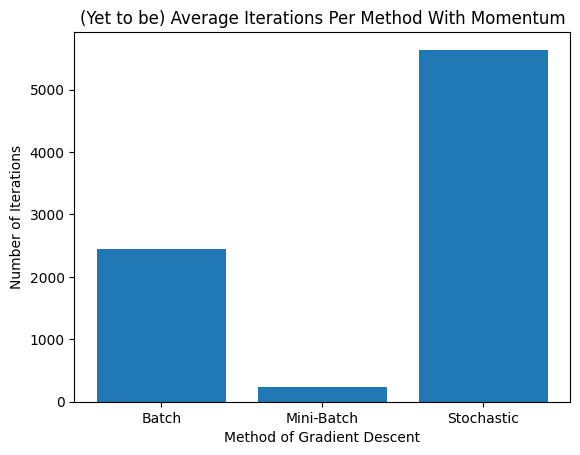

In [12]:
plot_loss_vs_epochs(momentum=0.1)